## Dependency installation and data downloading and unpacking

In [ ]:
# Install dependencies
!pip install spacy pandas numpy seaborn matplotlib scikit-learn

# For lemmatization, make sure spaCy is installed along with its english module
!python -m spacy download en_core_web_sm

In [ ]:
# Download and extract the dataset for NLP with Disaster Tweets Kaggle competition
# !kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

## Load / Reload project
This section just resets the dataframe to its original state

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Load the datasets
og_train_df = pd.read_csv("nlp-getting-started/train.csv")
og_test_df = pd.read_csv("nlp-getting-started/test.csv")

In [4]:
og_train_df["id"].value_counts().sum()
og_test_df["id"].value_counts().sum()

np.int64(3263)

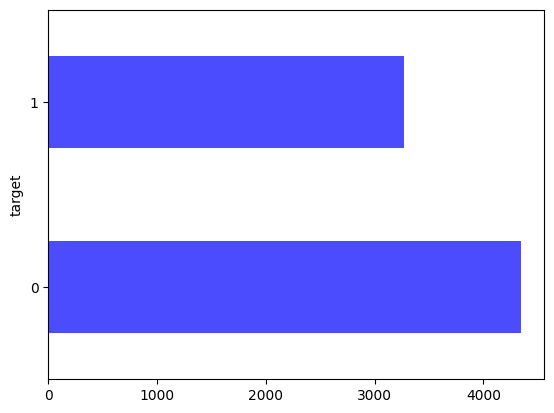

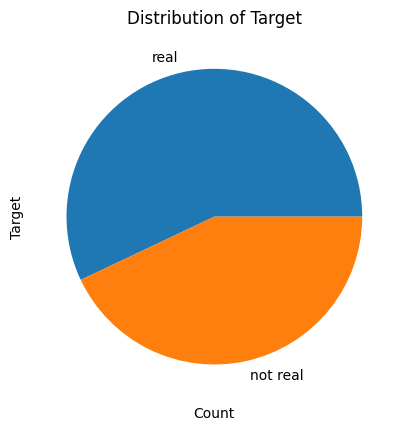

In [5]:
og_train_df["target"].value_counts().plot(kind='barh', color='blue', alpha=0.7)
plt.show()

plt.pie(og_train_df["target"].value_counts(), labels=["real", "not real"])
plt.xlabel("Count")
plt.ylabel("Target")
plt.title("Distribution of Target")
plt.show()

## Preprocessing
Preprocess the dataset before splitting it into the 70/30 distribution required by the assignment. Although we have followed the instruction's recommendations. We took some liberties with the order and depth to which we followed the instructions. Thus, our preprocesing consists of:

1. Removing punctuation  - This is helpful in standardizing the texts, but can create some isues in multiword lexical units and names. To solve this, a name entity recognition should be applied before this step.

2. Converting all text to lower case - As with the previous point, this help in standardization. Makes the text uniform and minimizes the influence of grammatical errors or stylized text.

3. Stopword removal - Stopwords are lexical units that have no semantic meaning; they are present to satisfy the syntactic requirements of the language. Thus, they are of little to no use to us in this assignment. The list of stopwords used in this program was provided on [this website](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt)

4. Lemmatization - This helps the system identify all lexemes of a lexical unit as a single lexical unit. Avoids redundant storage missuse and improves accuracy. For this step, due to implementational advantages brought by spaCy, spaCy was used instead of NLTK as the assignment description reccommended. 

5. Handling null values - This dataset contains some null values in some columns, thus we used the `pandas.fillna()` method to fill these spots. Text columns with an `No Value` string, and numeric columns with a Zero value.

6. Training dataset 70/30 split - Since our test dataset does not contain the target values we aim to predict, we must use a subset of our training set for the purposes of fine-tuning the model. Another option to consider would be running a k-fold structure.

In [18]:
# Remove punctuation to allow for better word manipulation, except in hyphenation cases, an exception we're willing to make given that this is not a deep linguistic analisys. However, if we wanted to maintain the most semantic context, a name entity recognition system should parse this text beforehand.
import string

print(og_train_df['text'].head())

# Remove punctuation using translate
og_train_df["text"] = og_train_df["text"].str.translate(str.maketrans("", "", string.punctuation))
print(og_train_df['text'].head())

0                 deed reason earthquake allah forgive
1                             forest ronge sask canada
2    resident ask shelter place notify officer evac...
3    13000 people receive wildfire evacuation order...
4         photo ruby alaska smoke wildfire pour school
Name: text, dtype: object
0                 deed reason earthquake allah forgive
1                             forest ronge sask canada
2    resident ask shelter place notify officer evac...
3    13000 people receive wildfire evacuation order...
4         photo ruby alaska smoke wildfire pour school
Name: text, dtype: object


In [19]:
# Convert text to lowercase
og_train_df['text'] = og_train_df['text'].str.lower()
print(og_train_df["text"].head())

0                 deed reason earthquake allah forgive
1                             forest ronge sask canada
2    resident ask shelter place notify officer evac...
3    13000 people receive wildfire evacuation order...
4         photo ruby alaska smoke wildfire pour school
Name: text, dtype: object


In [20]:
# Get the list of stopwords to be removed (stopwords list not mine)
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# This function takes a string and checks if each of its words is in the stopword list. If so, it removes it from the string
def remove_stopwords(text):
    if isinstance(text, str):  # Ensure the value is a string
        return " ".join([word for word in text.split() if word not in stopwords])
    return text

og_train_df['text'] = og_train_df['text'].apply(remove_stopwords)

print(og_train_df["text"].head())

0                 deed reason earthquake allah forgive
1                             forest ronge sask canada
2    resident shelter place notify officer evacuati...
3    13000 people receive wildfire evacuation order...
4         photo ruby alaska smoke wildfire pour school
Name: text, dtype: object


In [21]:
# Lemmatize the remaining words
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    if isinstance(text, str):  # Ensure input is a string
        return " ".join([token.lemma_ for token in nlp(text)])
    return text

# Apply to a specific column
og_train_df['text'] = og_train_df['text'].apply(lemmatize_text)

print(og_train_df['text'])

0                    deed reason earthquake allah forgive
1                                forest ronge sask canada
2       resident shelter place notify officer evacuati...
3       13000 people receive wildfire evacuation order...
4            photo ruby alaska smoke wildfire pour school
                              ...                        
7608    giant crane hold bridge collapse nearby httptc...
7609    ariaahrary thetawni control wild california no...
7610      m194 0104 utc5 volcano hawaii httptcozdtoyd8ebj
7611    police investigate ebike collide car portugal ...
7612    late raze northern california wildfire abc new...
Name: text, Length: 7613, dtype: object


In [22]:
# Replace NaNs on numerical columns
og_train_df[['keyword', 'location', 'text']] = og_train_df[['keyword', 'location', 'text']].fillna('')
og_train_df['target'] = og_train_df['target'].fillna(0)

In [23]:
from sklearn.model_selection import train_test_split

# Split DataFrame into 70% train and 30% test
train_df, test_df = train_test_split(og_train_df, test_size=0.3, random_state=42)
print(train_df.head(), test_df.head())

         id            keyword                location  \
1186   1707  bridge%20collapse                           
4071   5789               hail  Carol Stream, Illinois   
5461   7789             police                Houston    
5787   8257            rioting                           
7445  10656             wounds          Lake Highlands   

                                                   text  target  
1186  ashe 2015 australiaûªs collapse trent bridge ...       0  
4071  great michigan technique camp bmurph1019 haily...       1  
5461  cnn tennessee movie theater shooting suspect k...       1  
5787                    rioting couple hour leave class       1  
7445  crack path wipe morning beach surface wound le...       0           id      keyword               location  \
2644  3796  destruction                          
2227  3185       deluge                          
5448  7769       police                     UK   
132    191   aftershock                          
6845 

## Bag of Word -ing

As a first step towards making a bag of words, the words that each vector will contain must be chose. While we could use all of the words, this might be too computationally intensive. Furthermore, words with low apparitions would not add much to the model. Thus we do the following:

1. Count how many times each word appears

2. Analyze the correlation between words and target

3. Choose those words with the most appearances and highest correlation to target

In [ ]:
from collections import Counter

# Flatten all text data into a list of words
all_words = " ".join(train_df["text"]).split()
word_counts = Counter(all_words)

# Get the M most common words
M = 1000  # Example value
most_common_words = [word for word, count in word_counts.most_common(M)]



[('amp', 209),
 ('people', 152),
 ('news', 148),
 ('video', 129),
 ('2', 121),
 ('emergency', 119),
 ('burn', 116),
 ('kill', 114),
 ('attack', 114),
 ('year', 111),
 ('disaster', 111),
 ('bomb', 110),
 ('crash', 109),
 ('body', 105),
 ('flood', 101),
 ('time', 100),
 ('day', 99),
 ('man', 97),
 ('watch', 94),
 ('train', 92),
 ('family', 91),
 ('california', 88),
 ('police', 87),
 ('life', 83),
 ('suicide', 82),
 ('3', 81),
 ('scream', 81),
 ('work', 80),
 ('love', 80),
 ('collapse', 78),
 ('storm', 77),
 ('car', 77),
 ('live', 74),
 ('death', 73),
 ('nuclear', 72),
 ('feel', 72),
 ('wreck', 71),
 ('youtube', 71),
 ('building', 70),
 ('destroy', 69),
 ('drown', 68),
 ('accident', 67),
 ('hiroshima', 67),
 ('fear', 66),
 ('war', 65),
 ('report', 64),
 ('today', 64),
 ('good', 63),
 ('bag', 62),
 ('plan', 62),
 ('wildfire', 61),
 ('dead', 60),
 ('rescue', 58),
 ('wave', 58),
 ('service', 58),
 ('big', 58),
 ('weapon', 58),
 ('injury', 57),
 ('survive', 57),
 ('derail', 57),
 ('damage', 5